In [1]:
!pip install -U transformers
!pip install -U accelerate
!pip install -U datasets
!pip install -U bertviz
!pip install -U umap-learn
!pip install seaborn --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 72.2 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.46.2
    Uninstalling transformers-4.46.2:
      Successfully uninstalled transformers-4.46.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are

In [2]:
import pandas as pd
df = pd.read_csv("https://raw.githubusercontent.com/laxmimerit/All-CSV-ML-Data-Files-Download/master/twitter_multi_class_sentiment.csv")


In [3]:
df.shape

(16000, 3)

In [4]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        16000 non-null  object
 1   label       16000 non-null  int64 
 2   label_name  16000 non-null  object
dtypes: int64(1), object(2)
memory usage: 375.1+ KB


,0
text,0
label,0
label_name,0


In [5]:
df.describe()

,label
count,16000.000000
mean,1.565937
std,1.501430
min,0.000000
25%,0.000000
50%,1.000000
75%,3.000000
max,5.000000


In [6]:
df['label'].value_counts()

,count
label,
1,5362
0,4666
3,2159
4,1937
2,1304
5,572


**# dataset analyis**

In [7]:
import matplotlib.pyplot as plt

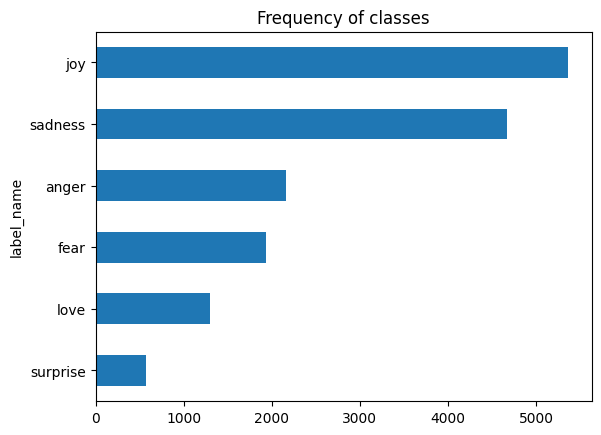

In [8]:
label_counts = df['label_name'].value_counts( ascending = True)
label_counts.plot.barh()
plt.title("Frequency of classes")
plt.show()

<Axes: title={'center': 'Words per Tweet'}, xlabel='label_name'>

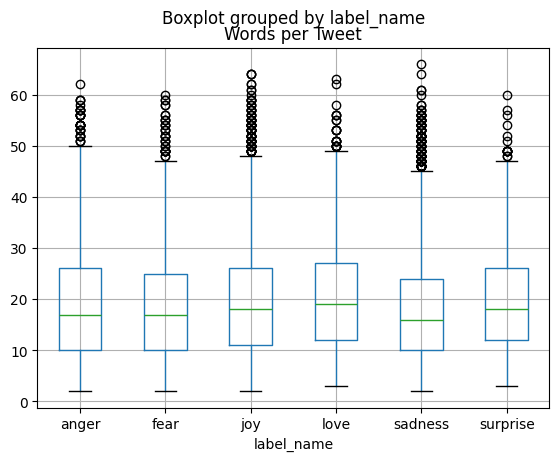

In [9]:
df['Words per Tweet'] = df['text'].str.split().apply(len)
df.boxplot("Words per Tweet", by="label_name")

**# Text to Tokens conversion**

In [10]:
from transformers import AutoTokenizer


model_ckpt = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

text ="I love machine learning! Tokenization is awesome!!"
encoded_text = tokenizer(text)
print(encoded_text)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

{'input_ids': [101, 1045, 2293, 3698, 4083, 999, 19204, 3989, 2003, 12476, 999, 999, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [11]:
encoded_text

{'input_ids': [101, 1045, 2293, 3698, 4083, 999, 19204, 3989, 2003, 12476, 999, 999, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [12]:
len(tokenizer.vocab), tokenizer.vocab_size, tokenizer.model_max_length

(30522, 30522, 512)

**# dataloader and Traintestsplit**

In [13]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.3,stratify = df['label_name'])
# train
test, validation = train_test_split(test, test_size=1/3, stratify=test['label_name'])
# train_test_split
train.shape, test.shape, validation.shape

((11200, 4), (3200, 4), (1600, 4))

In [14]:
from datasets import Dataset, DatasetDict

dataset = DatasetDict(
    {'train':   Dataset.from_pandas(train,preserve_index= False),
     'test' :   Dataset.from_pandas(test, preserve_index= False),
     'validation': Dataset.from_pandas(validation, preserve_index=False)
    }
)
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_name', 'Words per Tweet'],
        num_rows: 11200
    })
    test: Dataset({
        features: ['text', 'label', 'label_name', 'Words per Tweet'],
        num_rows: 3200
    })
    validation: Dataset({
        features: ['text', 'label', 'label_name', 'Words per Tweet'],
        num_rows: 1600
    })
})

**# Tokenization of the emotion and sentiment data**

In [15]:
dataset['train'][0], dataset['train'][1]

({'text': 'i began to feel accepted by gaia on her own terms',
  'label': 1,
  'label_name': 'joy',
  'Words per Tweet': 11},
 {'text': 'i feel accepted welcomed',
  'label': 2,
  'label_name': 'love',
  'Words per Tweet': 4})

In [16]:
def tokenize(batch):
    temp = tokenizer(batch['text'],padding= True, truncation= True)
    return temp

print(tokenize(dataset['train'][:2]))

{'input_ids': [[101, 1045, 2211, 2000, 2514, 3970, 2011, 11721, 2401, 2006, 2014, 2219, 3408, 102], [101, 1045, 2514, 3970, 10979, 102, 0, 0, 0, 0, 0, 0, 0, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]]}


In [17]:
emotion_encoded = dataset.map(tokenize, batched=True,batch_size=None)

Map:   0%|          | 0/11200 [00:00<?, ? examples/s]

Map:   0%|          | 0/3200 [00:00<?, ? examples/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

In [18]:
emotion_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_name', 'Words per Tweet', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 11200
    })
    test: Dataset({
        features: ['text', 'label', 'label_name', 'Words per Tweet', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3200
    })
    validation: Dataset({
        features: ['text', 'label', 'label_name', 'Words per Tweet', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1600
    })
})

In [19]:
#label2id, id2label
label2id={x['label_name']:x['label'] for x in dataset['train']}
id2label={ v:k for k, v in label2id.items()}

label2id , id2label

({'joy': 1, 'love': 2, 'anger': 3, 'sadness': 0, 'fear': 4, 'surprise': 5},
 {1: 'joy', 2: 'love', 3: 'anger', 0: 'sadness', 4: 'fear', 5: 'surprise'})

**# model building**

In [20]:
from transformers import AutoModel
import torch

In [21]:
model = AutoModel.from_pretrained(model_ckpt)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [22]:
# model.config.architectures
# model.config.bad_words_ids
model.config.id2label
model.config

BertConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.46.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

**# Fine tuning**

**# fine tuning**

In [23]:
from transformers import AutoModelForSequenceClassification, AutoConfig

num_labels = len(label2id)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = AutoConfig.from_pretrained(model_ckpt, label2id=label2id, id2label = id2label)


model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, config=config).to(device)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
model.config

BertConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "sadness",
    "1": "joy",
    "2": "love",
    "3": "anger",
    "4": "fear",
    "5": "surprise"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "anger": 3,
    "fear": 4,
    "joy": 1,
    "love": 2,
    "sadness": 0,
    "surprise": 5
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.46.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [25]:
from transformers import TrainingArguments
batch_size    = 64
training_dir  = "bert_base_train_dir"
training_args = TrainingArguments(output_dir=training_dir,
                              overwrite_output_dir =  True,
                              num_train_epochs = 2,
                              learning_rate = 2e-5,
                              per_device_train_batch_size = batch_size,
                              per_device_eval_batch_size = batch_size,
                              weight_decay= 0.01,
                              evaluation_strategy ='epoch',
                              disable_tqdm = False
                                 )

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


**# compute metrics-build compute metric function**

In [26]:
!pip install evaluate
import evaluate
import numpy as np
accuracy = evaluate.load("accuracy")
def compute_metrics_evaluate(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.1 MB/s eta 0:00:00


In [27]:
# use sklearn to build computer metrics
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds  = pred.predictions.argmax(-1)

    f1 = f1_score(labels,  preds, average= "weighted")
    acc= accuracy_score(labels, preds)

    return{"accuracy":acc , "f1": f1 }

**## build model and trainer**

In [29]:
from transformers import Trainer
trainer = Trainer(model=model , args=training_args,
                 compute_metrics= compute_metrics,
                 train_dataset= emotion_encoded['train'],
                 eval_dataset = emotion_encoded['validation'],
                 tokenizer    = tokenizer )

<ipython-input-29-aadc67170e59>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model , args=training_args,


In [30]:
# emotion_encoded
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.444561,0.875625,0.868687
2,No log,0.268330,0.918125,0.917082


TrainOutput(global_step=350, training_loss=0.6888028826032366, metrics={'train_runtime': 428.5996, 'train_samples_per_second': 52.263, 'train_steps_per_second': 0.817, 'total_flos': 1001502421516800.0, 'train_loss': 0.6888028826032366, 'epoch': 2.0})

In [ ]:
# model evaluation

In [31]:
preds_output = trainer.predict(emotion_encoded['test'])
preds_output.metrics

{'test_loss': 0.3053152859210968,
 'test_accuracy': 0.90125,
 'test_f1': 0.9001937096854846,
 'test_runtime': 12.9907,
 'test_samples_per_second': 246.329,
 'test_steps_per_second': 3.849}

In [32]:
y_pred = np.argmax(preds_output.predictions, axis =1)
y_true = emotion_encoded['test'][:]['label']

In [33]:
from sklearn.metrics import classification_report
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       933
           1       0.91      0.93      0.92      1072
           2       0.81      0.74      0.77       261
           3       0.94      0.89      0.91       432
           4       0.84      0.88      0.86       387
           5       0.79      0.67      0.72       115

    accuracy                           0.90      3200
   macro avg       0.87      0.84      0.86      3200
weighted avg       0.90      0.90      0.90      3200



In [34]:
label2id

{'joy': 1, 'love': 2, 'anger': 3, 'sadness': 0, 'fear': 4, 'surprise': 5}

In [35]:
# plot confusion matrix

In [37]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

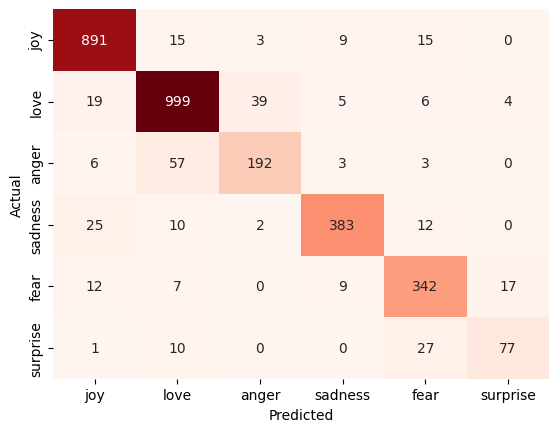

In [38]:
cm = confusion_matrix(y_true,y_pred)
sns.heatmap(cm, annot =True, xticklabels = label2id.keys(),yticklabels=label2id.keys(),fmt='d',cbar=False,cmap='Reds')
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

In [39]:
text= "I am super happy today I got it done finally"
def get_prediction(text):
    input_encoded = tokenizer(text, return_tensors ='pt').to(device)
    with torch.no_grad():
        outputs = model(**input_encoded)

    logits =outputs.logits
    pred = torch.argmax(logits,dim=1).item()
    return id2label[pred]

get_prediction(text)


'joy'

In [43]:
#use pipeline for predication
from transformers import pipeline

# Use a valid and publicly available model name from the Hugging Face Model Hub
# Example: 'distilbert-base-uncased-finetuned-sst-2-english'
classifier = pipeline('text-classification', model='distilbert-base-uncased-finetuned-sst-2-english')

classifier([text,'hello, how are you?',"love you","i am feeling low"])

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'label': 'POSITIVE', 'score': 0.9998724460601807},
 {'label': 'POSITIVE', 'score': 0.994739830493927},
 {'label': 'POSITIVE', 'score': 0.9998613595962524},
 {'label': 'NEGATIVE', 'score': 0.9997394680976868}]